# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("scipy")
sc.install_pypi_package("seaborn")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588538856473_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Importing

Now, import the installed packages from the previous block below.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [3]:
df_bus = spark.read.json('s3://big-data-spark1/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [2]:
print(f"Number of rows: {df_bus.count()}")
print(f"Number of columns: {len(df_bus.columns)}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows: 209393
Number of columns: 14

Display the DataFrame schema below.

In [18]:
df_bus.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [19]:
df_bus.select('business_id','name','city','state','categories','stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+-----+
|         business_id|                name|           city|state|          categories|stars|
+--------------------+--------------------+---------------+-----+--------------------+-----+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|  3.5|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|  5.0|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|  5.0|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|  2.5|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|  4.5|
+--------------------+--------------------+---------------+-----+--------------------+-----+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

# Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [20]:
import pyspark.sql.functions as fn
asso=df_bus.select('business_id', fn.explode(fn.split(df_bus.categories,', ')).alias('category'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [21]:
asso.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [22]:
asso.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [23]:
TopCat= asso.groupBy('category').count()
TopCat.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|      Data Recovery|  195|
|      Videographers|  169|
|      Skating Rinks|  104|
|             Fondue|   54|
|    Pet Photography|   49|
|  Pet Waste Removal|   34|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|       Aerial Tours|   28|
|  Signature Cuisine|    1|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|Private Jet Charter|   10|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [24]:
top20 = TopCat.sort('count', ascending=False).limit(20)
top20.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+

In [25]:
top20_pd = top20.toPandas()
top20_pd = top20_pd.iloc[::-1]



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

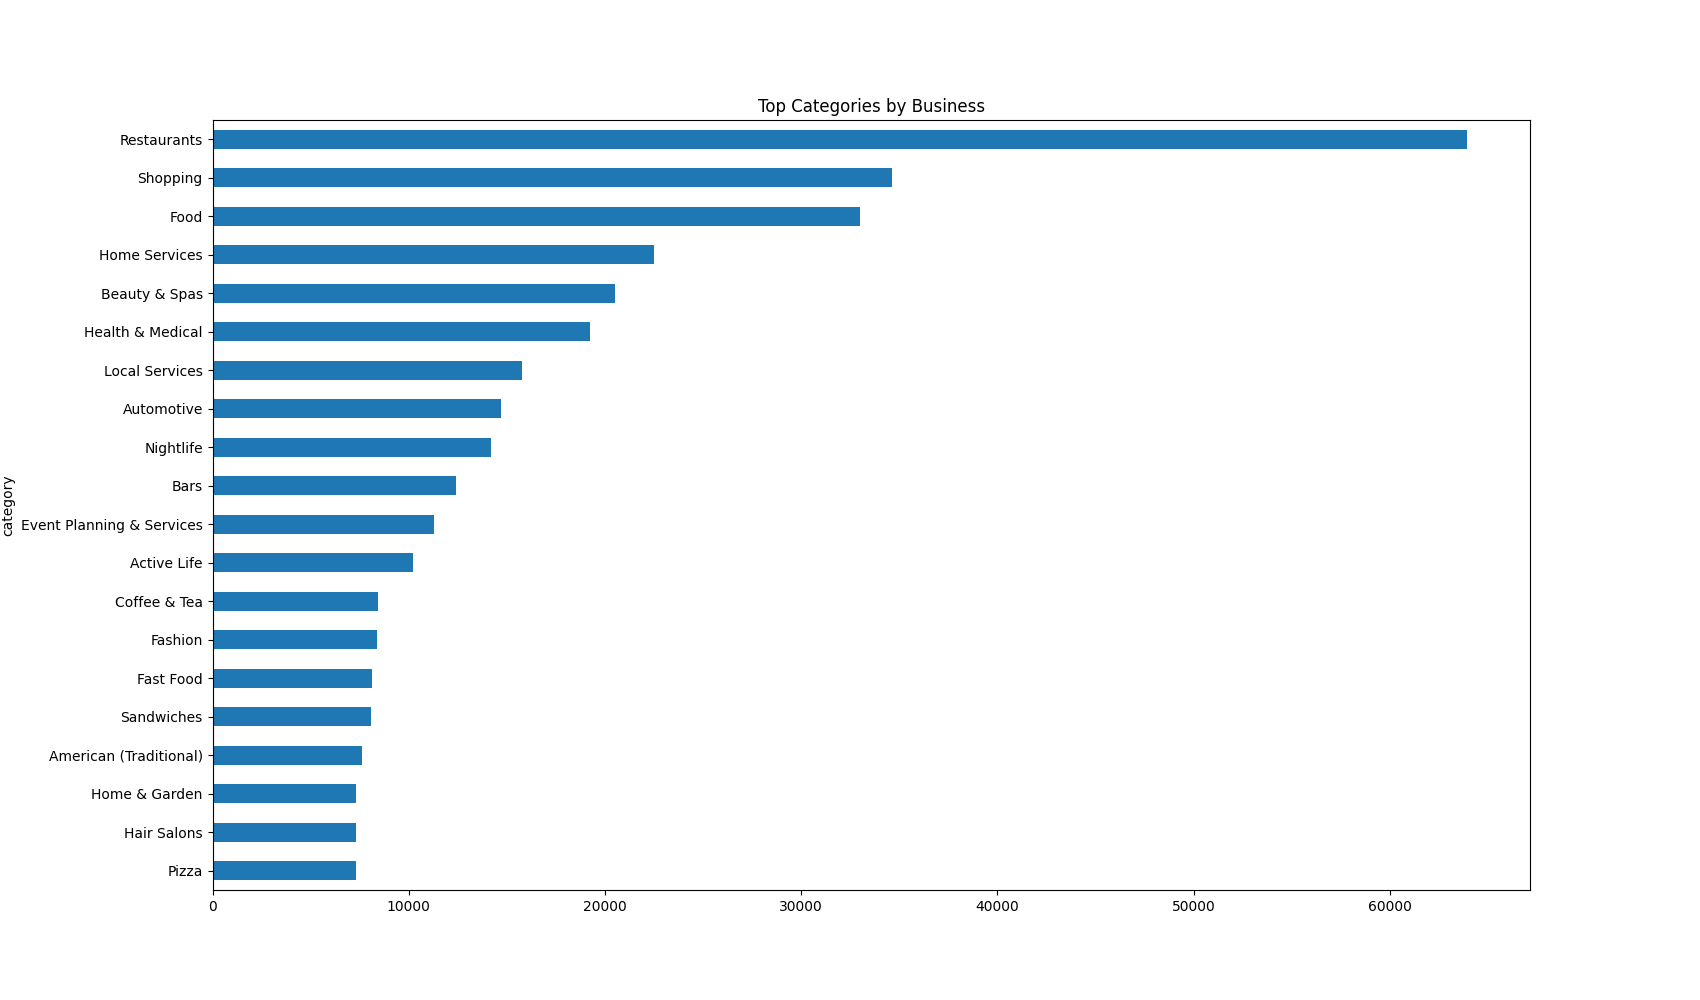

In [28]:
top20_pd.plot.barh(x='category', y='count', legend=False, position=0.5, figsize=(17,10),title='Top Categories by Business' )
%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.



## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [4]:
df_review = spark.read.json('s3://big-data-spark1/yelp_academic_dataset_review.json')
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [4]:
df_review.select('business_id', 'stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [9]:
HasReview = df_review.select('business_id','stars','text')
ReviewAvg = HasReview.groupBy('business_id').agg(fn.avg(HasReview.stars))
ReviewAvg.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|       avg(stars)|
+--------------------+-----------------+
|x1fx7C_tc064cFATj...|3.120967741935484|
|ATeOjZzE3VOI-RW7F...|3.433734939759036|
|kpbhERZoj1eTDRnMV...|2.033333333333333|
|vyu1WGlnHGv2Z2MVE...|              5.0|
|ipFreSFhjClfNETuM...|              2.6|
+--------------------+-----------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [10]:
Joined = ReviewAvg.join(df_bus.select('business_id','stars','name','city','state'), ReviewAvg.business_id == df_bus.business_id, 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [11]:
Joined = Joined.select('avg(stars)','stars','name','city','state')
Joined.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+
|        avg(stars)|stars|                name|       city|state|
+------------------+-----+--------------------+-----------+-----+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|
+------------------+-----+--------------------+-----------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [12]:
WithSkew = Joined.withColumn('skew', (Joined['avg(stars)']-Joined['stars'])/Joined['stars'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
WithSkew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+-----------+-----+--------------------+
|        avg(stars)|stars|                name|       city|state|                skew|
+------------------+-----+--------------------+-----------+-----+--------------------+
|  4.11784140969163|  4.0|Delmonico Steakhouse|  Las Vegas|   NV|0.029460352422907565|
|2.3333333333333335|  2.5|Neo-Paws Internat...|    Toronto|   ON|-0.06666666666666661|
|             4.375|  4.5| McFarling Law Group|  Las Vegas|   NV|-0.02777777777777...|
|3.3333333333333335|  3.5|Volvo of Mississauga|Mississauga|   ON|-0.04761904761904...|
|               5.0|  5.0|Andre Agassi Coll...|  Las Vegas|   NV|                 0.0|
+------------------+-----+--------------------+-----------+-----+--------------------+
only showing top 5 rows

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

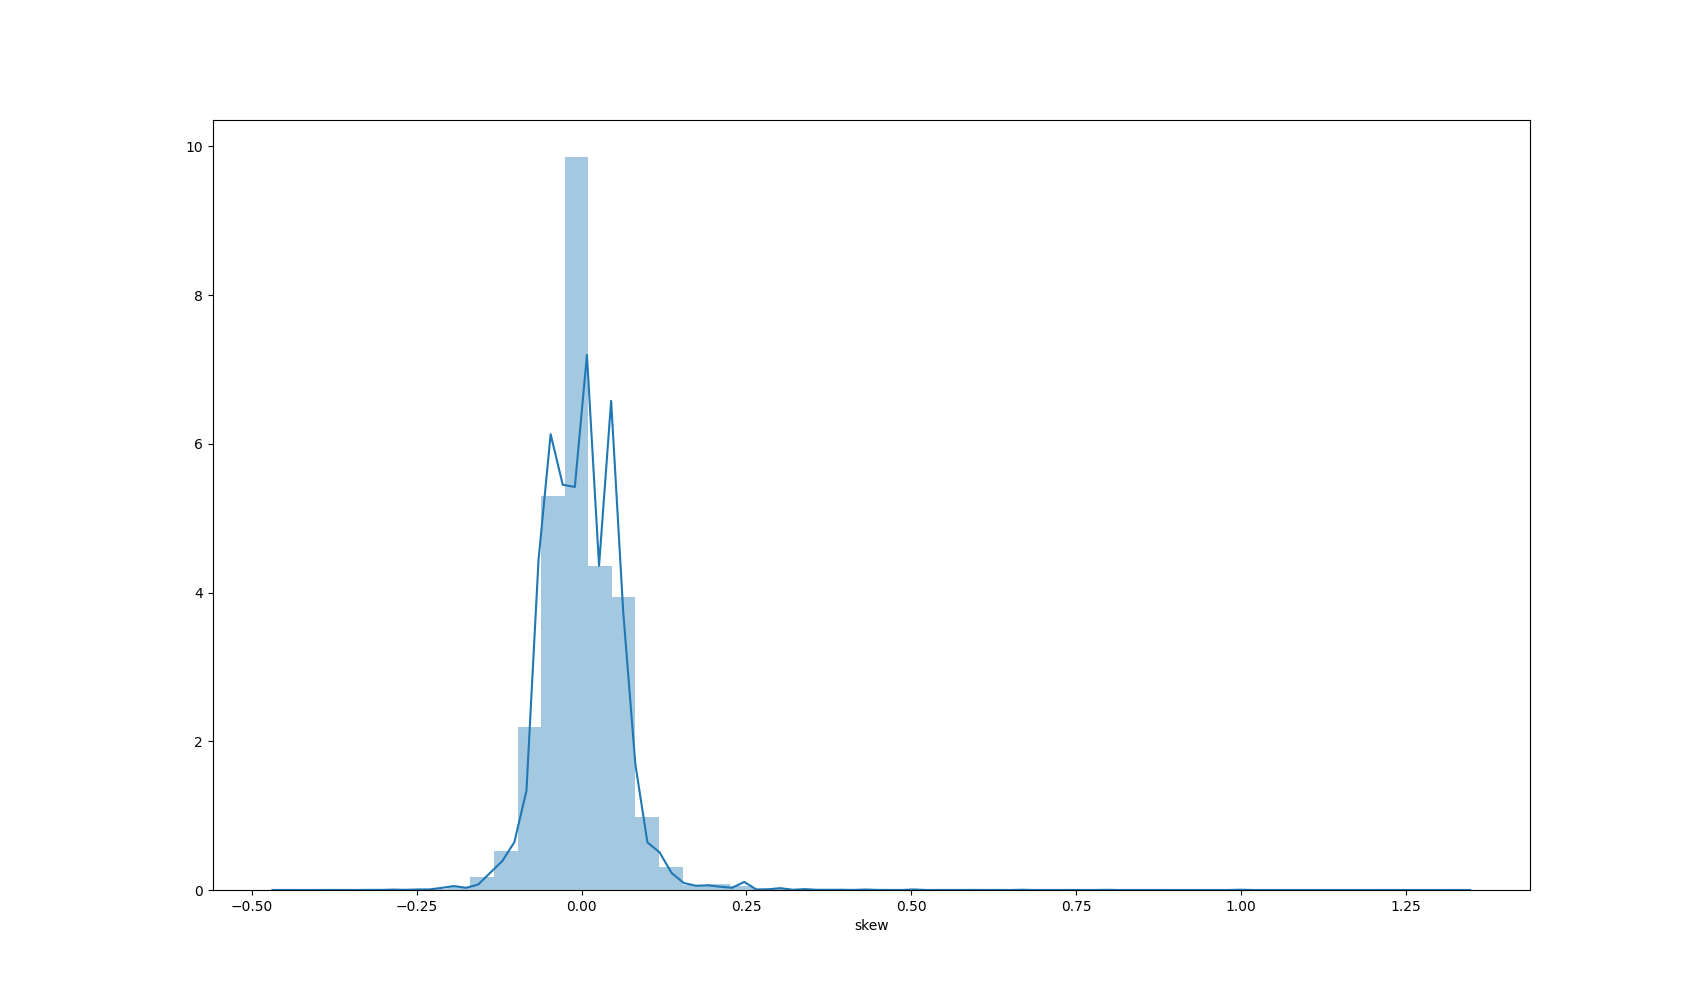

In [65]:
WithSkew_pd = WithSkew.select("name", "skew").toPandas()
plt.clf()
sns.distplot(WithSkew_pd['skew'])
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

Answer - No, the negative and positive reviews are almost split half and half in the graph. (it's symetric.)
This anylsis proves that the motivations for people to write reviews can be negative and positive and the chances are almost equal. 

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis


Answer -  No, the Elite should not be trusted. Because from the graph below we can see that the distribution is skewed to the right, which means that the Elite are likely to give more stars than the actual business rating.

In [5]:
df_user = spark.read.json('s3://big-data-spark1/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df_user.select('name', 'review_count','yelping_since','useful','funny','cool','elite','fans','average_stars').show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------------+-------------------+------+-----+----+--------------------+----+-------------+
|        name|review_count|      yelping_since|useful|funny|cool|               elite|fans|average_stars|
+------------+------------+-------------------+------+-----+----+--------------------+----+-------------+
|      Rafael|         553|2007-07-06 03:27:11|   628|  225| 227|                    |  14|         3.57|
|    Michelle|         564|2008-04-28 01:29:25|   790|  316| 400|2008,2009,2010,20...|  27|         3.84|
|      Martin|          60|2008-08-28 23:40:05|   151|  125| 103|                2010|   5|         3.44|
|        John|         206|2008-09-20 00:08:14|   233|  160|  84|                2009|   6|         3.08|
|        Anne|         485|2008-08-09 00:30:27|  1265|  400| 512|2009,2010,2011,20...|  78|         4.37|
|       Steve|         186|2007-02-27 07:09:40|   642|  192| 155|                2007|  15|         2.88|
|      Stuart|          12|2010-05-12 16:30:08

In [9]:
Elite = df_user.select('user_id', 'elite').filter(fn.length('elite')>0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
Review_elite = df_review.join(Elite, df_review.user_id==Elite.user_id, 'inner')

Elite_avg = Review_elite.groupBy('business_id').agg(fn.avg(Review_elite.stars).alias('EliteStars')).select('business_id', 'EliteStars')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
Final = Elite_avg.join(df_bus, Elite_avg.business_id == df_bus.business_id, 'inner').select(df_bus.business_id,Elite_avg.EliteStars,df_bus.stars)

Final = Final.withColumn('TrustScore', Final['EliteStars']-Final['stars'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

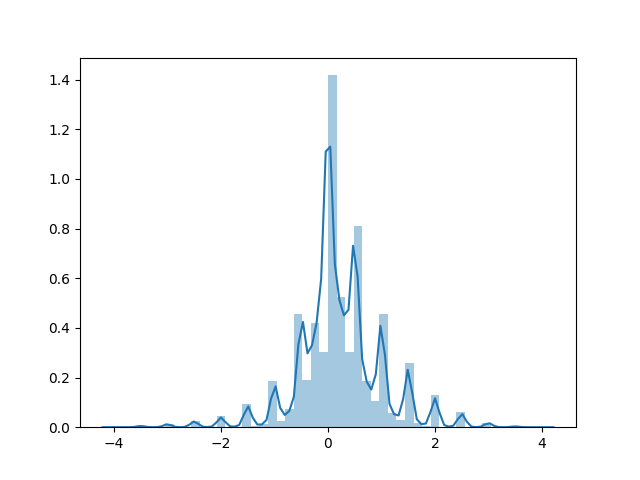

In [37]:
Final_pd = Final.select('TrustScore').toPandas()
plt.clf()
sns.distplot(Final_pd)
%matplot plt